# Semantic segmentation of unexpected objects on roads

## Setup

In [1]:
SEED = 42

DATA_DIR = "./data"
CHECKPOINTS_DIR = "./weights"

RUN_NON_RELEVANT = False
LOAD_PREFITTED = True
RUN_EVALUATION = False

In [2]:
# !mkdir -p $DATA_DIR
# !wget -O $DATA_DIR/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
# !wget -O $DATA_DIR/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
# !tar -xf $DATA_DIR/train.tar -C $DATA_DIR
# !tar -xf $DATA_DIR/test.tar -C $DATA_DIR

In [3]:
%load_ext autoreload
%autoreload 2

import os
import json
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import lightning as L
import torchvision
from torchvision import transforms

from utils.street_hazards import StreetHazardsDataset, StreetHazardsClasses, visualize_scene, visualize_annotation, visualize_anomaly, show_results
from utils.eval import evaluate_model
from utils.predictor import StandardPredictor, SmoothedPredictor

from models.utils.PretrainedSegmenter import PretrainedSegmenter
from models.max_logit import MaxLogitModel, MaxSoftmaxModel, StandardizedMaxLogitModel
from models.knn import KNNModel, KmeansModel, extract_hidden_states, sample_hidden_states
from utils.misc import dataset_subset

from typing import Union

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEEPLABV3_MOBILE_VIT_S_MAIN_DIR = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd01_no-weighted_resize")
DEEPLABV3_MOBILE_VIT_S_ABL_LOWER_DECAY_DIR = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd001_no-weighted_resize")
DEEPLABV3_MOBILE_VIT_S_ABL_HIGHER_DECAY_DIR = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd02_no-weighted_resize")
DEEPLABV3_MOBILE_VIT_S_ABL_WEIGHTED_DIR = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd01_weighted_resize")
DEEPLABV3_MOBILE_VIT_S_ABL_CROP_DIR = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd01_no-weighted_crop")
DEEPLABV3_MOBILE_VIT_XS_ABL_DIR = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-x-small")
DEEPLABV3_MOBILENET_ABL_DIR = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilenet")

DATA_TRAIN_ODGT = os.path.join(DATA_DIR, "train/train.odgt")
DATA_VAL_ODGT = os.path.join(DATA_DIR, "train/validation.odgt")
DATA_TEST_ODGT = os.path.join(DATA_DIR, "test/test.odgt")

2025-01-25 22:03:25.014054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 22:03:25.026536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 22:03:25.029932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 22:03:25.039994: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 22:03:25.842107: W tensorflow/compiler/tf2

## Utilities

In [4]:
def plot_loss(df_logs: pd.DataFrame):
    df_train_step_loss = df_logs[["step", "train_loss"]][~df_logs["train_loss"].isna()]
    df_train_epoch_loss = df_logs.groupby(["epoch"]).agg({"step": "max", "train_loss": "mean"})[["step", "train_loss"]]
    df_val_epoch_loss = df_logs[["step", "val_loss"]][~df_logs["val_loss"].isna()]
    last_step_per_epoch = df_train_epoch_loss["step"]
    
    plt.plot(df_train_epoch_loss["step"], df_train_epoch_loss["train_loss"], label="Train loss (epoch)")
    plt.plot(df_val_epoch_loss["step"], df_val_epoch_loss["val_loss"], label="Val loss (epoch)")
    plt.plot(df_train_step_loss["step"], df_train_step_loss["train_loss"], "--", alpha=0.6, label="Train loss (step)")

    plt.xlabel("Step")
    plt.ylabel("Loss")
    sec = plt.gca().secondary_xaxis(location="top")
    sec.set_xticks(last_step_per_epoch, labels=range(len(last_step_per_epoch)))
    sec.set_xlabel("Epoch")
    plt.ylim(top=df_train_epoch_loss["train_loss"].max() * 1.1) # Ignore first steps of train loss as it is (usually) too large
    plt.legend()
    plt.grid()


def plot_miou(df_logs: pd.DataFrame):
    df_train_epoch_miou = df_logs[["epoch", "train_miou"]][~df_logs["train_miou"].isna()]
    df_val_epoch_miou = df_logs[["epoch", "val_miou"]][~df_logs["val_miou"].isna()]

    plt.plot(df_train_epoch_miou["epoch"], df_train_epoch_miou["train_miou"], label="Train mIoU (epoch)")
    plt.plot(df_val_epoch_miou["epoch"], df_val_epoch_miou["val_miou"], label="Val mIoU (epoch)")

    plt.ylabel("mIoU")
    plt.xlabel("Epoch")
    plt.xticks(df_train_epoch_miou["epoch"])
    plt.legend()
    plt.grid()


def plot_logs(df_logs):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plot_loss(df_logs)
    plt.subplot(1, 2, 2)
    plot_miou(df_logs)
    
    plt.show()

In [5]:
class PredictorContainer:
    def __init__(self, predictor, name):
        self.predictor = predictor
        self.name = name

    def __call__(self, inputs):
        return self.predictor(inputs)
    

def _loadMaxSoftmaxModel(segmenter):
    return MaxSoftmaxModel(segmenter)

def _loadMaxLogitModel(segmenter):
    return MaxLogitModel(segmenter)

def _loadStandardizedMaxLogitModel(segmenter, use_prefitted, ds_train, save_fitted=True, ckp_path="."):
    model_std_maxlogit = StandardizedMaxLogitModel(segmenter)
    if use_prefitted:
        model_std_maxlogit.load(os.path.join(ckp_path, "stdmaxlogit.pkl"))
    else:
        model_std_maxlogit.fit(DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10))
        if save_fitted: model_std_maxlogit.save(os.path.join(ckp_path, "stdmaxlogit.pkl"))
    return model_std_maxlogit

def _loadKNNModel(segmenter, use_prefitted, hidden_states, hidden_states_index=-1, save_fitted=True, ckp_path="."):
    model_knn = KNNModel(segmenter, hidden_states_index=hidden_states_index)
    if use_prefitted:
        model_knn.load(os.path.join(ckp_path, f"knn_2000_{hidden_states_index}.pkl"))
    else:
        model_knn.fit(sample_hidden_states(hidden_states, 2000, SEED))
        if save_fitted: model_knn.save(os.path.join(ckp_path, f"knn_2000_{hidden_states_index}.pkl"))
    return model_knn

def _loadKMeansModel(segmenter, use_prefitted, hidden_states, hidden_states_index=-1, save_fitted=True, ckp_path="."):
    model_kmeans = KmeansModel(segmenter, hidden_states_index=hidden_states_index)
    if use_prefitted:
        model_kmeans.load(os.path.join(ckp_path, f"kmeans_2000_{hidden_states_index}.pkl"))
    else:
        model_kmeans.fit(hidden_states)
        if save_fitted: model_kmeans.save(os.path.join(ckp_path, f"kmeans_2000_{hidden_states_index}.pkl"))
    return model_kmeans

def prepare_predictors(
        segmenter_card,
        segmenter_ckp_path,
        PredictorClass = SmoothedPredictor,
        ds_train = None,
        use_prefitted = True,
        label = None,
        save_fitted = True,
        segmenter_args = {},
        hidden_states_index = -1,
        include = None
    ):
    segmenter = PretrainedSegmenter.get(segmenter_card, **segmenter_args).to(DEVICE)
    segmenter.load_state_dict(torch.load(os.path.join(segmenter_ckp_path, "checkpoint.pt"), weights_only=True))

    hidden_states = None
    if (not use_prefitted) and (include is None or "knn" in include or "kmeans" in include):
        hidden_states = extract_hidden_states(segmenter, DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10), hidden_states_index)
    label = "" if label is None else f" ({label})"
    predictors = {}

    if (include is None) or ("maxsoftmax" in include):
        model_maxsoftmax = _loadMaxSoftmaxModel(segmenter)
        predictors["maxsoftmax"] = PredictorContainer( PredictorClass(model_maxsoftmax), "Maximum softmax"+label )
    if (include is None) or ("maxlogit" in include):
        model_maxlogit = _loadMaxLogitModel(segmenter)
        predictors["maxlogit"] = PredictorContainer( PredictorClass(model_maxlogit), "MaxLogit"+label )
    if (include is None) or ("std_maxlogit" in include):
        model_std_maxlogit = _loadStandardizedMaxLogitModel(segmenter, use_prefitted, ds_train, save_fitted, segmenter_ckp_path)
        predictors["std_maxlogit"] = PredictorContainer( PredictorClass(model_std_maxlogit), "Standardized MaxLogit"+label )
    if (include is None) or ("knn" in include):
        model_knn = _loadKNNModel(segmenter, use_prefitted, hidden_states, hidden_states_index, save_fitted, segmenter_ckp_path)
        predictors["knn"] = PredictorContainer( PredictorClass(model_knn), "k-NN"+label )
    if (include is None) or ("kmeans" in include):
        model_kmeans = _loadKMeansModel(segmenter, use_prefitted, hidden_states, hidden_states_index, save_fitted, segmenter_ckp_path)
        predictors["kmeans"] = PredictorContainer( PredictorClass(model_kmeans), "k-means + k-NN"+label )

    return predictors

In [6]:
def evaluate_models(predictors: Union[dict[PredictorContainer], PredictorContainer], dataset: torch.utils.data.Dataset, compute_miou=True, compute_ap=True):
    all_results = []
    if isinstance(predictors, PredictorContainer): predictors = { "_": predictors }

    for config in predictors.values():
        L.seed_everything(SEED, verbose=False)
        results = evaluate_model(config.predictor, dataset, device=DEVICE, compute_miou=compute_miou, compute_ap=compute_ap)
        all_results.append({ "model": config.name, **results })

    return all_results

def evaluate_segmenter(predictor: PredictorContainer, dataset: torch.utils.data.Dataset, label=""):
    L.seed_everything(SEED, verbose=False)
    results = evaluate_model(predictor.predictor, dataset, device=DEVICE, compute_miou=True, compute_ap=False)
    return [{ "model": label, **results }]


def display_results(results: list[dict], caption=""):
    df = pd.DataFrame.from_dict(results)
    if "miou" in df.columns: df["miou"] = df["miou"].apply(lambda x: f"{x*100:.2f}")
    if "ap" in df.columns: df["ap"] = df["ap"].apply(lambda x: f"{x*100:.2f}")
    df.drop(columns=df.columns.difference(["model", "miou", "ap"]), errors="ignore", inplace=True)
    df.rename(columns={"model": "Model", "miou": "mIoU", "ap": "AUPR"}, errors="ignore", inplace=True)
    df = df.style \
            .hide(axis="index") \
            .set_caption(caption)
    display(df)

def display_classwise_iou(results: list[dict], caption=""):
    iou_c = results[0]["iou_c"] # Results are all the same for the same segmenter
    df = pd.DataFrame([iou_c], columns=[f"IoU_{c.name}" for c in StreetHazardsClasses if c != StreetHazardsClasses.ANOMALY])
    for c in df.columns:
        df[c] = df[c].apply(lambda x: f"{x*100:.2f}")
    df = df.style \
            .hide(axis="index") \
            .set_caption(caption)
    display(df)

---
---

## 1. Introduction

### 1.1. Overall approach

The approach taken to solve the problem follows the idea of many proposals presented in the literature and consists of:
1. Training a model for closed-set semantic segmentation.
2. Adding the anomaly detector on top of the segmentation model.

For the segmentation task, the idea is to experiment with small models. The architecture of choice is DeepLabV3 with MobileViT-small as feature extractor. This choice is to allow running more experiments which with a bigger architecture would not be possible due to the limited computing resources. Moreover, most of the approaches proposed in the literature tend to use large networks, so it could be nice to have a scaling comparison with them. Finally, in a more practical point-of-view, a smaller model is also more portable and cheaper for real-time predictions, which is a reasonable requirement for this task.

For the anomaly detection module, the implemented approach uses as starting point the method based on nearest-neighbor proposed by [Galesso *et al.*](https://arxiv.org/abs/2211.06660v2) with some additional experiments with $k$-means to reduce the feature space. Moreover, an additional smoothing step with superpixel segmentation using SLIC has been experimented with the goal of aligning predictions with the objects in the image.

### 1.1.2. Metrics and evaluation

The required metrics are computed as follows:
- mIoU is computed using the implementation provided by [DeepLabV3+](https://github.com/VainF/DeepLabV3Plus-Pytorch/blob/master/metrics/stream_metrics.py) which accumulates a confusion matrix and computes the metric after processing all required samples (this follows the definition given during the lectures). As a side note, other libraries that compute the average individual mIoUs have been discarded.
- AUPR is computed using scikit-learn by averaging the `average_precision_score` of each individual sample.

To have some baselines, as in many other papers, the MaxLogit method proposed by [Hendrycks *et al.*](https://arxiv.org/abs/1911.11132) is used. In addition, the standardized MaxLogit method proposed by [Jung *et al.*](https://arxiv.org/abs/2107.11264) is also considered.

### 1.3. Notebook structure
The next sections of the notebook are structured as follows:
- Section 2 presents some preliminary analysis on the dataset.
- Section 3 describes the pipeline and some training information.
- Section 4 presents the overall qualitative and quantitative results.
- Section 5 contains the results of ablation study.
- Section 6 concludes with some final remarks.

---
## 2. Dataset

In [7]:
ds_train = StreetHazardsDataset(DATA_TRAIN_ODGT)
ds_val = StreetHazardsDataset(DATA_VAL_ODGT)
__ds_test = StreetHazardsDataset(DATA_TEST_ODGT)

### 2.1. Anomalous validation set

The pipeline chosen to solve the task has some hyperparameters that need to be tuned. However, the available validation set does not have anomalies, making this step impossible without leaking the test set.

In the literature, there are a few papers such as DenseHybrid proposed by [Grcić *et al.*](https://arxiv.org/abs/2207.02606v1) or RPL by [Liu *et al.*](https://arxiv.org/abs/2211.14512) that augment the training set by pasting external objects and considering them as anomalies. Taking some inspiration from this, a second validation set for tuning is created starting from the original one and by randomly pasting objects taken from PASCAL VOC.

In [8]:
ds_val_anomalies = StreetHazardsDataset(DATA_VAL_ODGT, add_random_anomalies=True)
ds_val_anomalies = dataset_subset(ds_val_anomalies, 500, SEED)

### 2.2. Data exploration

In [9]:
print(f"Training set size:   {len(ds_train)}")
print(f"Validation set size: {len(ds_val)}")
print(f"Test set size:       {len(__ds_test)}")

Training set size:   5125
Validation set size: 1031
Test set size:       1500


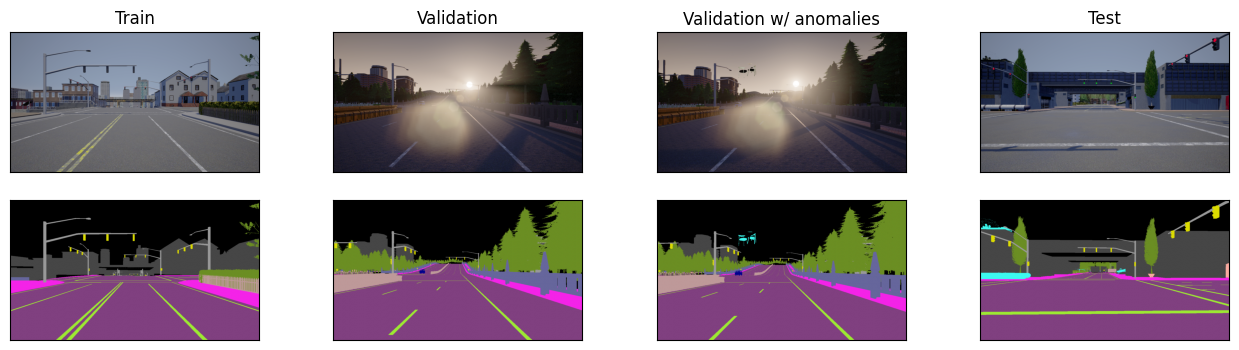

In [10]:
train_image, train_label = ds_train[0]
val_image, val_label = ds_val[0]
val_anom_image, val_anom_label = ds_val_anomalies[0]
test_image, test_label = __ds_test[0]

plt.figure(figsize=(16, 4))
plt.subplot(2, 4, 1)
plt.title("Train")
visualize_scene(train_image)
plt.subplot(2, 4, 2)
plt.title("Validation")
visualize_scene(val_image)
plt.subplot(2, 4, 3)
plt.title("Validation w/ anomalies")
visualize_scene(val_anom_image)
plt.subplot(2, 4, 4)
plt.title("Test")
visualize_scene(test_image)
plt.subplot(2, 4, 5)
visualize_annotation(train_label)
plt.subplot(2, 4, 6)
visualize_annotation(val_label)
plt.subplot(2, 4, 7)
visualize_annotation(val_anom_label)
plt.subplot(2, 4, 8)
visualize_annotation(test_label)
plt.show()

By diving deeper into the data, it can be observed that there are both instances of independent scenes and consecutive ones. As the task is on single images, it is safe to assume that temporal/spatial dependencies are not relevant. Therefore, no particular considerations are needed when forming a training batch regarding this aspect.

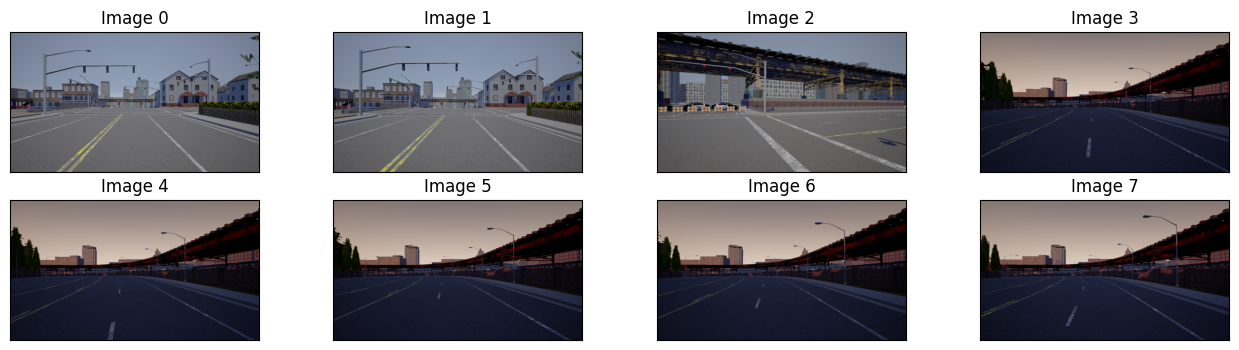

In [11]:
plt.figure(figsize=(16, 4))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.title(f"Image {i}")
    visualize_scene(ds_train[i][0])

In terms of class distribution, it can be seen from the plot below that the classes are roughly unbalanced in the same way across all three splits. This indicates that there is no need for reweighing the loss function when training. To empirically confirm this, in the section on ablation study, a weighted model is also experimented with.

In [12]:
def get_class_counts(ds, num_classes=14):
    class_counts = [0] * num_classes

    for i in tqdm(range(len(ds))):
        classes, counts = ds[i][1].unique(return_counts=True)
        for j in range(len(classes)):
            class_counts[classes[j]] += counts[j].item()

    return np.array(class_counts)

def plot_class_distribution(class_counts, title="", scale="linear", num_classes=14):
    plt.barh(range(len(class_counts)), class_counts)
    plt.title(title)
    plt.xlabel(f"Count ({scale})")
    plt.ylabel("Class")
    plt.yticks(range(num_classes))
    plt.xscale(scale)


if RUN_NON_RELEVANT:
    class_count_train = get_class_counts(ds_train)
    class_count_val = get_class_counts(ds_val)
    class_count_test = get_class_counts(__ds_test)
else:
    class_count_train = np.array([1465351059, 567381185, 58982347, 22047241, 868060, 58867769, 63524255, 1573790159, 316983236, 416765104, 11689770, 162203306, 4746509, 0])
    class_count_val = np.array([269463074, 120766393, 21536012, 4309583, 20319, 5780099, 12482596, 344159100, 42262849, 98579343, 375774, 29420657, 1013801, 0])
    class_count_test = np.array([424877639, 166108644, 15544806, 8193403, 0, 10774864, 25619696, 515092874, 53327213, 119629690, 2149430, 24534419, 2303533, 14243789])
    
class_freq_train = class_count_train / class_count_train.sum()
class_freq_val = class_count_val / class_count_val.sum()
class_freq_test = class_count_test / class_count_test.sum()

,Split,UNLABELED (0),BUILDING (1),FENCE (2),OTHER (3),PEDESTRIAN (4),POLE (5),ROAD_LINE (6),ROAD (7),SIDEWALK (8),VEGETATION (9),CAR (10),WALL (11),TRAFFIC_SIGN (12),ANOMALY (13)
0,Train,31.025%,12.013%,1.249%,0.467%,0.018%,1.246%,1.345%,33.320%,6.711%,8.824%,0.247%,3.434%,0.100%,0.000%
1,Val,28.359%,12.710%,2.267%,0.454%,0.002%,0.608%,1.314%,36.221%,4.448%,10.375%,0.040%,3.096%,0.107%,0.000%
2,Test,30.735%,12.016%,1.124%,0.593%,0.000%,0.779%,1.853%,37.261%,3.858%,8.654%,0.155%,1.775%,0.167%,1.030%


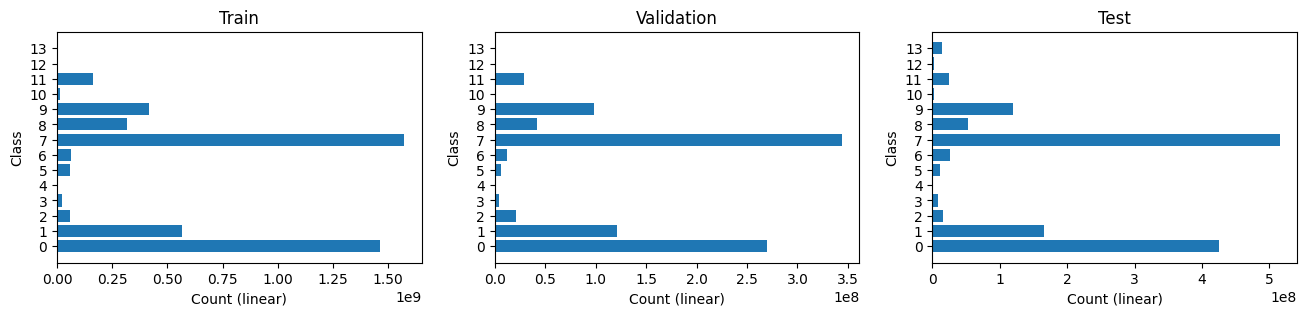

In [13]:
display(
    pd.DataFrame(
        data = [
            ["Train"] + [f"{freq*100:.3f}%" for freq in class_freq_train],
            ["Val"] + [f"{freq*100:.3f}%" for freq in class_freq_val],
            ["Test"] + [f"{freq*100:.3f}%" for freq in class_freq_test],
        ],
        columns = ["Split"] + [f"{c.name} ({c.value})" for c in StreetHazardsClasses]
    )
)

plt.figure(figsize=(16, 3))
plt.subplot(1, 3, 1)
plot_class_distribution(class_count_train, title="Train", scale="linear")
plt.subplot(1, 3, 2)
plot_class_distribution(class_count_val ,title="Validation", scale="linear")
plt.subplot(1, 3, 3)
plot_class_distribution(class_count_test, title="Test", scale="linear")
plt.show()

A small consideration must be made for the class UNLABELED and OTHER. From a visual analysis, it can be seen that UNLABELED is used to represent the background, which is mostly the sky. However, there are instances where other elements (which seems like bridges, elevated railways, …) are included in the background. OTHER also seems to represent multiple different objects. This could be a source of misclassifications, but it would require manual annotations to remove them.

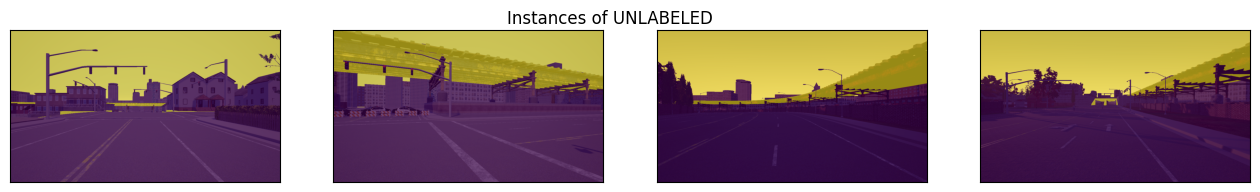

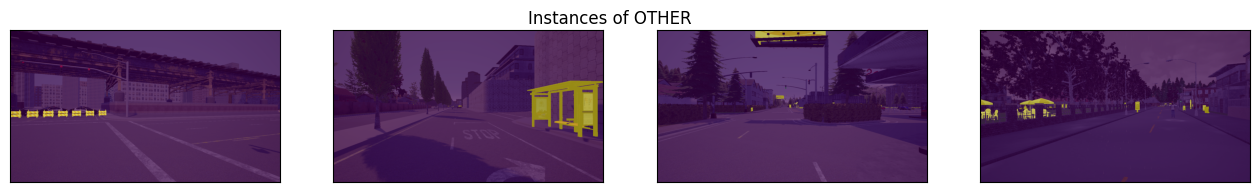

In [14]:
plt.figure(figsize=(16, 2))
plt.suptitle("Instances of UNLABELED")
for i, idx in enumerate([0, 2, 3, 150]):
    plt.subplot(1, 4, i+1)
    visualize_scene(ds_train[idx][0])
    plt.imshow(ds_train[idx][1] == StreetHazardsClasses.UNLABELED, alpha=0.6)
plt.show()

plt.figure(figsize=(16, 2))
plt.suptitle("Instances of OTHER")
for i, idx in enumerate([2, 2100, 2700, 3800]):
    plt.subplot(1, 4, i+1)
    visualize_scene(ds_train[idx][0])
    plt.imshow(ds_train[idx][1] == StreetHazardsClasses.OTHER, alpha=0.6)
plt.show()

---
## 3. Method

### 3.1. Workflow

The overall method does the following for inference:
1. Down-sample the input image to a resolution of $512 \times 512$ (the one required by MobileViT) and pass it through the DeepLabV3-MobileViT-S model.
2. The closed-set semantic segmentation task is solved using the up-scaled output logits.
3. Consider the embeddings outputted by MobileViT ($160 \times 32 \times 32$ if reshaped to be image-like). For each of them, compute the distance to the nearest (precomputed) training embedding to obtain a distance matrix $32 \times 32$.
4. Up-sample the distance matrix to match the image resolution and obtain the anomaly scores.
5. Use SLIC to segment the input image into superpixels. 
6. For each superpixel, its anomaly score is the average anomaly score of every pixel within it. The new anomaly map is used to solve the anomaly segmentation task.

For superpixel segmentation, although there are many algorithms, SLIC has been chosen as it has a fast implementation in Python.

In [15]:
segmenter = PretrainedSegmenter.get("apple/deeplabv3-mobilevit-small").to(DEVICE)
segmenter.load_state_dict(torch.load(os.path.join(DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, "checkpoint.pt"), weights_only=True))

<All keys matched successfully>

### 3.2. Training details

#### 3.2.1. Segmentation model

The training configuration for the best model is the following:
- AdamW as optimizer.
- $2 \cdot 10^{-4}$ as learning rate.
- $0.1$ for weight decay.
- Cross entropy as loss.
- 30 epochs of training with early stopping monitoring mIoU.

The choice of the optimizer follows the current best practices. For the learning rate, smaller and bigger values were tried and the chosen one has been found to have the best balance between convergence speed and performance. The choice of weight decay will be analyzed in ablation study to show that smaller values perform worse.

Moreover, as MobileViT-S works with $512 \times 512$ images and to speed-up training, both training images and annotations are down-sampled to that shape. As other methods in the literature work with crops, this choice is assessed in ablation study.

A notable observation that can be made on the training plots is that the validation loss and mIoU tend to not be correlated. In fact, during training the loss tend to slightly worsen while mIoU improves. This can be interpreted as a resulting model whose output distribution do not show a clear majority.

Max validation mIoU: 0.5104833841323853


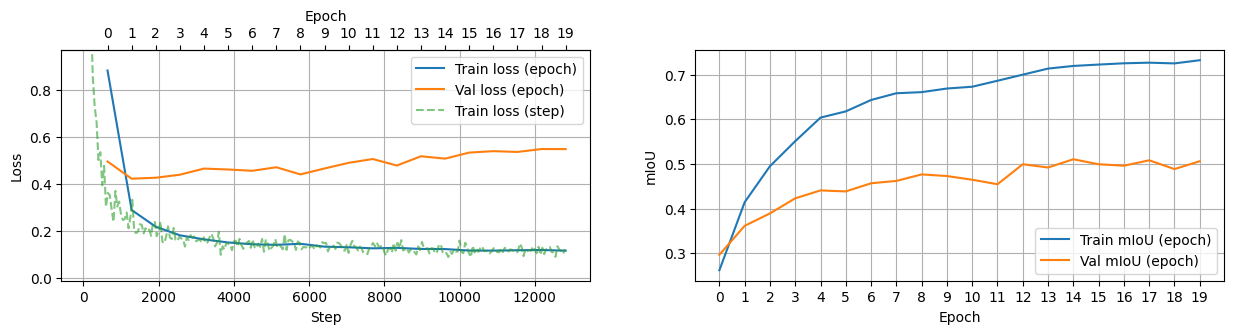

In [16]:
df_logs = pd.read_csv(os.path.join(DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, "logs.csv"))

print(f"Max validation mIoU: {df_logs['val_miou'].max()}")
plot_logs(df_logs)
plt.show()

#### 3.2.2. Anomaly detector

To "train" the $k$-NN model for anomaly detection, a subset of the training set (to speed-up computation) is considered and all the embeddings from those images are computed. All these embeddings are used to fit a $k$-means model and the centroids are used as the actual samples used by $k$-NN (i.e., the number of samples $k$-NN has available is the same as the number of $k$-means clusters).

### 3.3. Hyperparameter tuning

The anomaly detector has some hyperparameters that have to be determined. To tune them, as previously mentioned, the validation set with artificially added anomalies is used.

In this section, the following hyperparameters are tuned:
- The number of neighbors to consider in $k$-NN.
- The number of clusters $k$-means has to determine (i.e., the amount of data points $k$-NN need to have available).
- The hyperparameters of SLIC for smoothing.

#### 3.3.1. Number of neighbors

In terms of number of neighboring embeddings to compare the query against, it can be seen that the performance in terms of AUPR decreases linearly with the number of neighbors. Therefore, a single neighbor is the best choice to determine anomalies.

In [17]:
if RUN_NON_RELEVANT:
    to_test_num_neighbors = range(1, 11)
    num_neighbors_results = []
    hidden_states = extract_hidden_states(segmenter, DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10))
    hidden_states_for_fit = sample_hidden_states(hidden_states, 1000, SEED)

    for num_neighbors in to_test_num_neighbors:
        print(f"Running with num_neighbors={num_neighbors}")
        model = KNNModel(segmenter, n_neighbors=num_neighbors).fit(hidden_states_for_fit)
        predictor = StandardPredictor(model)

        L.seed_everything(SEED, verbose=False)
        results = evaluate_model(predictor, ds_val_anomalies, device=DEVICE, compute_miou=False)
        num_neighbors_results.append({ "num_neighbors": num_neighbors, "ap": results["ap"] })
else:
    num_neighbors_results = [{'num_neighbors': 1, 'ap': 0.1947749275854813}, {'num_neighbors': 2, 'ap': 0.19427496482412013}, {'num_neighbors': 3, 'ap': 0.1920241408182454}, {'num_neighbors': 4, 'ap': 0.1903389060749364}, {'num_neighbors': 5, 'ap': 0.18832123094585423}, {'num_neighbors': 6, 'ap': 0.18543473705050106}, {'num_neighbors': 7, 'ap': 0.1823873308670997}, {'num_neighbors': 8, 'ap': 0.17939995289702093}, {'num_neighbors': 9, 'ap': 0.17655490481809324}, {'num_neighbors': 10, 'ap': 0.17387920358866743}]

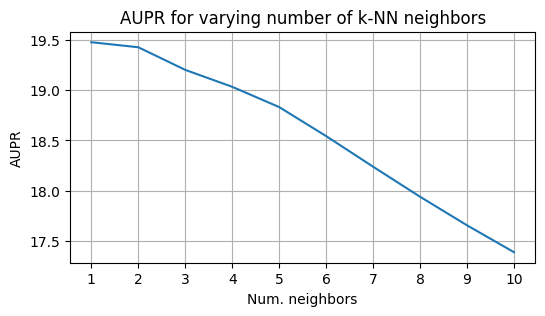

In [18]:
plt.figure(figsize=(6, 3))
plt.title("AUPR for varying number of k-NN neighbors")
plt.plot([r["num_neighbors"] for r in num_neighbors_results], [r["ap"]*100 for r in num_neighbors_results])
plt.xticks([r["num_neighbors"] for r in num_neighbors_results])
plt.xlabel("Num. neighbors")
plt.ylabel("AUPR")
plt.grid()
plt.show()

#### 3.3.2. Number of k-NN data points / Number of clusters

In terms of amount of samples $k$-NN should have available, it can be seen that performance grows by increasing data points.

In this analysis, the pool of available embeddings is computed on a subset of the training sets, then:
- For plain $k$-NN, the data points are determined by randomly sampling the desired number from the pool.
- For $k$-NN with $k$-means, the data points are the centroids determined by $k$-means with the number of clusters equal to the desired number of data points.

As $k$-means requires more time to converge for increasing number of clusters, the experiments were not done on large numbers. Still, it can be seen that choosing the samples for $k$-NN with $k$-means allows achieving better results compared to randomly sampling them.

In [19]:
if RUN_NON_RELEVANT:
    num_clusters_results = []
    knn_num_data_results = []
    hidden_states = extract_hidden_states(segmenter, DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10))

    for num_data in [10, 100, 200, 500, 1000, 2000, 3000]:
        print(f"Running for {num_data} datapoints")
        L.seed_everything(SEED, verbose=False)
        model = KmeansModel(segmenter, num_clusters=num_data).fit(hidden_states)
        predictor = StandardPredictor(model)
        results = evaluate_model(predictor, ds_val_anomalies, device=DEVICE, compute_miou=False)
        num_clusters_results.append({ "num_data": num_data, "ap": results["ap"] })

        print(f"Running for {num_data} datapoints")
        L.seed_everything(SEED, verbose=False)
        model = KNNModel(segmenter).fit(sample_hidden_states(hidden_states, num_data, SEED))
        predictor = StandardPredictor(model)
        results = evaluate_model(predictor, ds_val_anomalies, device=DEVICE, compute_miou=False)
        knn_num_data_results.append({ "num_data": num_data, "ap": results["ap"] })
else:
    num_clusters_results = [{'num_data': 10, 'ap': 0.1538137367637375}, {'num_data': 100, 'ap': 0.198616565412227}, {'num_data': 200, 'ap': 0.22836983660226468}, {'num_data': 500, 'ap': 0.2491150936026216}, {'num_data': 1000, 'ap': 0.2566104139132997}, {'num_data': 2000, 'ap': 0.2669750973605973}, {'num_data': 3000, 'ap': 0.2731835068297395}]
    knn_num_data_results = [{'num_data': 10, 'ap': 0.06898287623348882}, {'num_data': 100, 'ap': 0.13497221214065835}, {'num_data': 200, 'ap': 0.1562451390782702}, {'num_data': 500, 'ap': 0.1798926314242656}, {'num_data': 1000, 'ap': 0.1947749275854813}, {'num_data': 2000, 'ap': 0.22507075749081937}, {'num_data': 3000, 'ap': 0.2383407392217743}]

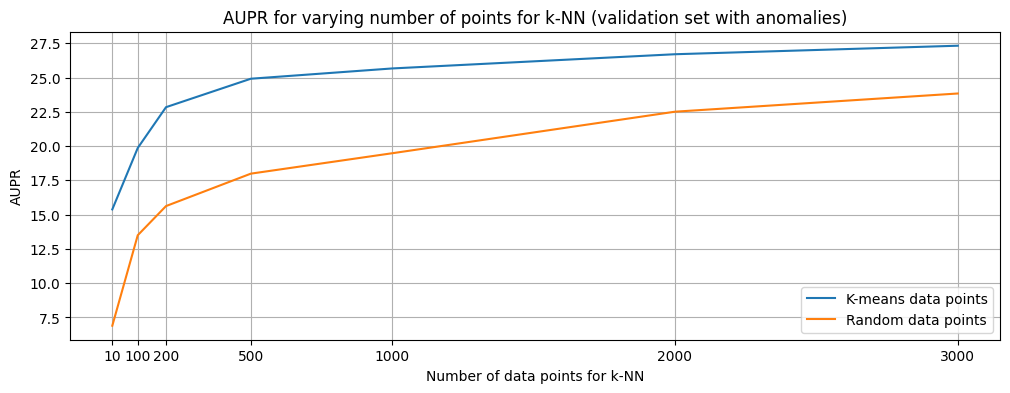

In [20]:
plt.figure(figsize=(12, 4))
plt.title("AUPR for varying number of points for k-NN (validation set with anomalies)")
plt.plot([r["num_data"] for r in num_clusters_results], [r["ap"]*100 for r in num_clusters_results], label="K-means data points")
plt.plot([r["num_data"] for r in knn_num_data_results], [r["ap"]*100 for r in knn_num_data_results], label="Random data points")
plt.xticks([r["num_data"] for r in knn_num_data_results])
plt.xlabel("Number of data points for k-NN")
plt.ylabel("AUPR")
plt.legend()
plt.grid()
plt.show()

#### 3.3.3. Smoothing hyperparameters

To check whether smoothing improves anomaly predictions, grid-search is performed on the hyperparameters of SLIC. As tuning is done on two parameters, the results can be visualized in a heatmap. It can be see that, compared to the baseline without smoothing, introducing SLIC greatly improves the results in terms of AUPR.

In [21]:
to_test_num_components = [100, 200, 500]
to_test_compactness = [0.1, 1, 10, 20, 50, 75, 100]

if RUN_NON_RELEVANT:
    slic_params_results_matrix = np.zeros((len(to_test_num_components), len(to_test_compactness)))
    hidden_states = extract_hidden_states(segmenter, DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10))
    model = KmeansModel(segmenter).fit(hidden_states)

    baseline = evaluate_model(StandardPredictor(model), ds_val_anomalies, device=DEVICE, compute_miou=False)

    for i, num_components in enumerate(to_test_num_components):
        for j, compactness in enumerate(to_test_compactness):
            print(f"Running with num_components={num_components}, compactness={compactness}")
            predictor = SmoothedPredictor(model, smooth_segmentation=False, smooth_anomaly=True, slic_num_components=num_components, slic_compactness=compactness)

            L.seed_everything(SEED, verbose=False)
            results = evaluate_model(predictor, ds_val_anomalies, device=DEVICE, compute_miou=False)
            slic_params_results_matrix[i, j] = results["ap"]
else:
    baseline = {'ap': 0.24684597070087647}
    slic_params_results_matrix = np.array([[0.24318989993435458, 0.24973245019701226, 0.28867382852519263, 0.30414008769919, 0.31033516695997926, 0.29463003550033584, 0.2811797009902454], [0.27771807517112, 0.28514103156452475, 0.32499905359979236, 0.3338013193868192, 0.32841435445089756, 0.3155366617597291, 0.30313539504503284], [0.29439742797690355, 0.3038211558380716, 0.3252118199542317, 0.32313133413051703, 0.3141073519389178, 0.30907129360895935, 0.3005564408505728]])

Baseline AUPR (without smoothing): 24.68


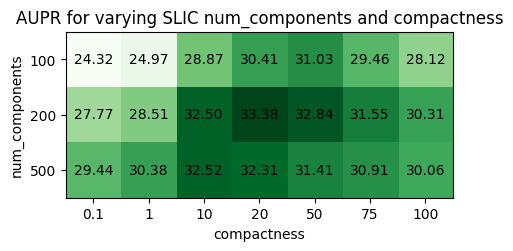

In [22]:
print(f"Baseline AUPR (without smoothing): {baseline['ap']*100:.2f}")

plt.figure(figsize=(5, 6))
plt.imshow(slic_params_results_matrix, cmap="Greens")
plt.title("AUPR for varying SLIC num_components and compactness")
for i in range(len(to_test_num_components)):
    for j in range(len(to_test_compactness)):
        text = plt.text(j, i, f"{slic_params_results_matrix[i, j]*100:.2f}", ha="center", va="center")
plt.xticks(range(len(to_test_compactness)), labels=to_test_compactness)
plt.yticks(range(len(to_test_num_components)), labels=to_test_num_components)
plt.xlabel("compactness")
plt.ylabel("num_components")
plt.show()

In qualitative terms, this configuration produces anomaly maps split in sections. Although fragmented, from a visual evaluation it can be seen that each section is more or less part of the same entity, therefore achieving the initial goal.

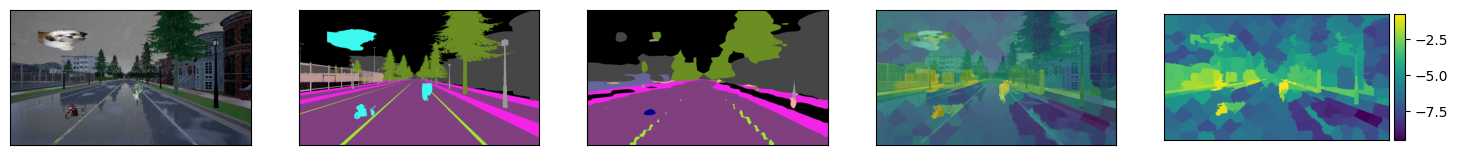

In [23]:
model = MaxLogitModel(segmenter)
predictor = SmoothedPredictor(model, smooth_segmentation=False, smooth_anomaly=True, slic_num_components=200, slic_compactness=20)

L.seed_everything(SEED, verbose=False)
image, labels = ds_val_anomalies[42]
segm_preds, ood_scores = predictor(image.to(DEVICE).unsqueeze(0))
segm_preds, ood_scores = segm_preds.cpu(), ood_scores.cpu()

show_results(image, labels, segm_preds[0], ood_scores[0])

Finally, applying smoothing to the segmentation maps has also been attempted. In this case, instead of averaging, the most frequent class in a patch is considered.

Results show that the overall mIoU worsens with smoothing. From a visual analysis, it can be seen that applying SLIC helps to improve the predictions of some objects (e.g., trees), but it disrupts others by mixing them with neighboring predictions.

In [24]:
model = MaxLogitModel(segmenter)
standard_predictor = StandardPredictor(model)
smoothed_predictor = SmoothedPredictor(model, smooth_segmentation=True, smooth_anomaly=True)

if RUN_NON_RELEVANT:
    segm_smoothing_results = evaluate_models([
        (standard_predictor, "Baseline segmenter"), 
        (smoothed_predictor, "Smoothed segmenter")
    ], ds_val, compute_ap=False)
else:
    segm_smoothing_results = [ {"model": "Baseline segmenter", "miou": 0.5104538146487005}, {"model": "Smoothed segmenter", "miou": 0.44923482556334665} ]

In [25]:
display_results(segm_smoothing_results)

Model,mIoU
Baseline segmenter,51.05
Smoothed segmenter,44.92


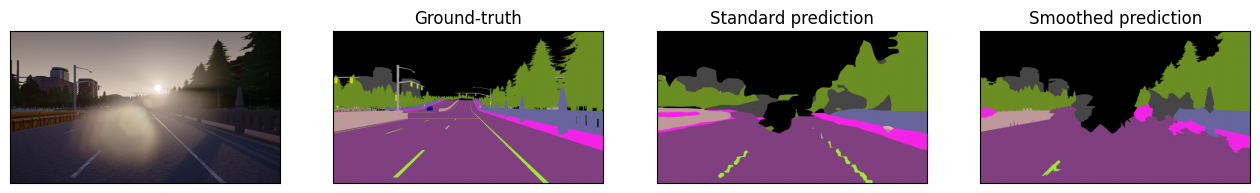

In [26]:
image, labels = ds_val[0]
standard_segm_map, _ = standard_predictor(image.unsqueeze(0).to(DEVICE))
smoothed_segm_map, _ = smoothed_predictor(image.unsqueeze(0).to(DEVICE))

plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
visualize_scene(image)
plt.subplot(1, 4, 2)
plt.title("Ground-truth")
visualize_annotation(labels)
plt.subplot(1, 4, 3)
plt.title("Standard prediction")
visualize_annotation(standard_segm_map.cpu().squeeze(0))
plt.subplot(1, 4, 4)
plt.title("Smoothed prediction")
visualize_annotation(smoothed_segm_map.cpu().squeeze(0))
plt.show()

---
## 4. Results

In [27]:
all_results = {
    "val": {},
    "val_anom": {},
    "test": {}
}

In [28]:
predictors_main = prepare_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, 
    PredictorClass = SmoothedPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED
)

### 4.1. Quantitative results

In [29]:
if RUN_EVALUATION:
    all_results["test"]["main"] = evaluate_models(predictors_main, __ds_test)
else:
    all_results["test"]["main"] = [{'model': 'Maximum softmax', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.11962491213490274}, {'model': 'MaxLogit', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.11680217327898083}, {'model': 'Standardized MaxLogit', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.08750892588810064}, {'model': 'k-NN', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.1310349022021817}, {'model': 'k-means + k-NN', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.13973137304926161}]

In [30]:
display_results(all_results["test"]["main"])
display_classwise_iou(all_results["test"]["main"])

Model,mIoU,AUPR
Maximum softmax,48.30,11.96
MaxLogit,48.30,11.68
Standardized MaxLogit,48.30,8.75
k-NN,48.30,13.10
k-means + k-NN,48.30,13.97


IoU_UNLABELED,IoU_BUILDING,IoU_FENCE,IoU_OTHER,IoU_PEDESTRIAN,IoU_POLE,IoU_ROAD_LINE,IoU_ROAD,IoU_SIDEWALK,IoU_VEGETATION,IoU_CAR,IoU_WALL,IoU_TRAFFIC_SIGN
84.73,70.89,29.52,29.85,0.00,13.90,32.98,94.42,67.80,75.99,58.62,51.13,18.09


### 4.2. Qualitative results

#### 4.2.1. Closed-set segmentation

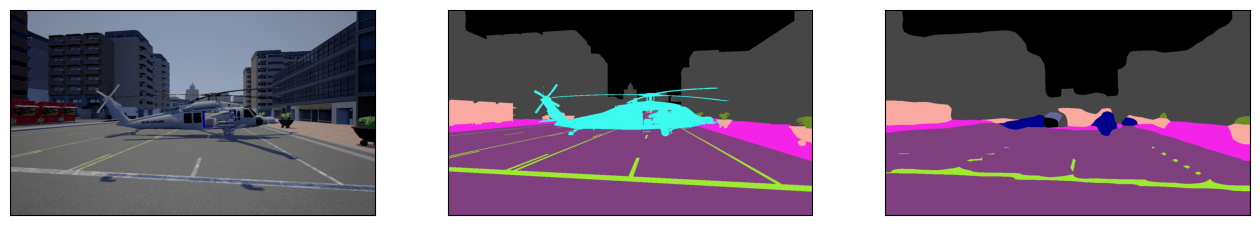

In [31]:
image, labels = __ds_test[1024]
segm_map, ood_scores = predictors_main["kmeans"](image.unsqueeze(0).to(DEVICE))
segm_map = segm_map.cpu().squeeze(0)

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
visualize_scene(image)
plt.subplot(1, 3, 2)
visualize_annotation(labels)
plt.subplot(1, 3, 3)
visualize_annotation(segm_map)

#### 4.2.2. Anomaly segmentation

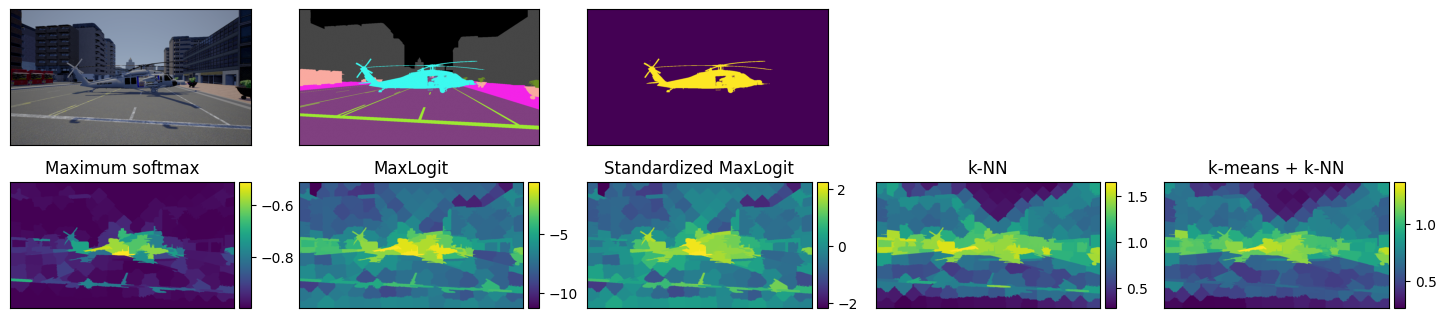

In [32]:
image, labels = __ds_test[1024]
_, ood_scores_maxsoftmax = predictors_main["maxsoftmax"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_maxlogit = predictors_main["maxlogit"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_std_maxlogit = predictors_main["std_maxlogit"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_knn = predictors_main["knn"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_kmeans = predictors_main["kmeans"](image.unsqueeze(0).to(DEVICE))

plt.figure(figsize=(18, 4))
plt.subplot(2, 5, 1)
visualize_scene(image)
plt.subplot(2, 5, 2)
visualize_annotation(labels)
plt.subplot(2, 5, 3)
visualize_anomaly(labels == StreetHazardsClasses.ANOMALY)
plt.subplot(2, 5, 6)
plt.title("Maximum softmax")
visualize_anomaly(ood_scores_maxsoftmax.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 5, 7)
plt.title("MaxLogit")
visualize_anomaly(ood_scores_maxlogit.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 5, 8)
plt.title("Standardized MaxLogit")
visualize_anomaly(ood_scores_std_maxlogit.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 5, 9)
plt.title("k-NN")
visualize_anomaly(ood_scores_knn.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 5, 10)
plt.title("k-means + k-NN")
visualize_anomaly(ood_scores_kmeans.cpu().squeeze(0), colorbar=True)

---
## 5. Ablation study

This section presents the results of ablation study. The investigation can be divided in three areas:
- Training recipe: check the effects of the training choices.
- Segmentation architecture: check how a smaller or bigger architecture affects the results.
- Anomaly detector: check how different choices for the anomaly detector change the results.

Although not ideal, as there is no official validation set that can be used to check the anomaly detector, the test set, along side the validation set, is used to perform ablation. The artificially created validation set, despite being useful for hyperparameter tuning, is not representative of the real data an is therefore not an ideal candidate to check design choices.

In [33]:
ds_val_anomalies = StreetHazardsDataset(DATA_VAL_ODGT, add_random_anomalies=True)

In [34]:
if RUN_EVALUATION:
    all_results["val"]["main"] = evaluate_segmenter(predictors_main["kmeans"], ds_val, "Segmenter")
    all_results["val_anom"]["main"] = evaluate_models(predictors_main["kmeans"], ds_val_anomalies)
else:
    all_results["val"]["main"] = [{'model': 'Segmenter', 'miou': 0.5104538146487005, 'iou_c': [0.8502693730805905, 0.7782005016115813, 0.31883027046917184, 0.3740129647716634, 0.3207813050456022, 0.13640429102910176, 0.3671863850896293, 0.9235283904530082, 0.6454786676602626, 0.7883368617912305, 0.46022134904105144, 0.4895308278110441, 0.18311840257916906]}]
    # all_results["val_anom"]["main"] = [{'model': 'k-means + k-NN', 'miou': 0.47047376637902844, 'iou_c': [0.8482244065442088, 0.7721646018511203, 0.3004418983532618, 0.34274448218232956, 0.06562703760052163, 0.1336815870432678, 0.3615898434476134, 0.9206359110847429, 0.636738245912039, 0.7854702975250939, 0.280590462129206, 0.48915323499937113, 0.17909695425459343], 'ap': 0.3348860305792509}]

display_results(all_results["val"]["main"], caption="Baseline segmenter on val set")
# display_results(all_results["val_anom"]["main"], caption="Baseline on validation set with anomalies")
display_results([all_results["test"]["main"][-1]], caption="Baseline on test set")

Model,mIoU
Segmenter,51.05


Model,mIoU,AUPR
k-means + k-NN,48.30,13.97


### 5.1. Training recipe

To investigate the effectiveness of the training hyperparameters, the following experiments are performed:
- Use a lower weight decay.
- Use a higher weight decay.
- Use a weighted loss.
- Train with random crops instead of resizing.

#### 5.1.1. Lower weight decay

By using a smaller weight decay, it can be observed that mIoU decreases a bit. However, no significant differences can be noted on the test set. 

In [35]:
predictors_low_decay = prepare_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_ABL_LOWER_DECAY_DIR, 
    PredictorClass = SmoothedPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "lower weight decay",
    include = ["kmeans"]
)


if RUN_EVALUATION:
    all_results["val"]["low_decay"] = evaluate_segmenter(predictors_low_decay["kmeans"], ds_val, "Segmenter (lower weight decay)")
    # all_results["val_anom"]["low_decay"] = evaluate_models(predictors_low_decay["kmeans"], ds_val_anomalies)
    all_results["test"]["low_decay"] = evaluate_models(predictors_low_decay["kmeans"], __ds_test)
else:
    all_results["val"]["low_decay"] = [{'model': 'Segmenter (lower weight decay)', 'miou': 0.5090487687646001, 'iou_c': [0.8474986483293182, 0.7653217925018895, 0.39659724503481814, 0.34461179171930334, 0.2992749395782982, 0.1511820013124342, 0.3994969634456577, 0.9255116627898051, 0.682538427951868, 0.7823007071436962, 0.5027802673749114, 0.3740531265738711, 0.14646642018393105]}]
    # all_results["val_anom"]["low_decay"] = [{'model': 'k-means + k-NN (lower weight decay)', 'miou': 0.4738096623694024, 'iou_c': [0.8458191924914958, 0.7625076649567206, 0.39079713177499414, 0.32107622125979773, 0.060740200859601925, 0.14786958578094322, 0.3935108263087551, 0.9224960312174911, 0.6763497474336337, 0.7783423107618166, 0.3391700317346458, 0.3781360953357251, 0.14271057088661135], 'ap': 0.2980597615952017}]
    all_results["test"]["low_decay"] = [{'model': 'k-means + k-NN (lower weight decay)', 'miou': 0.4749099569350084, 'iou_c': [0.8541831276025406, 0.6955504095962014, 0.3323702792791485, 0.28669765208994624, 0.0, 0.15972112131122176, 0.337901112438839, 0.9365369541113787, 0.6661405268240189, 0.7584129083285995, 0.5829998401733787, 0.4076489437590134, 0.1556665646408218], 'ap': 0.13618310741955036}]


display_results(all_results["val"]["low_decay"] + all_results["val"]["main"], caption="Results on validation set")
# display_results(all_results["val_anom"]["low_decay"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")
display_results(all_results["test"]["low_decay"] + [all_results["test"]["main"][-1]], caption="Results on test set")

Model,mIoU
Segmenter (lower weight decay),50.90
Segmenter,51.05


Model,mIoU,AUPR
k-means + k-NN (lower weight decay),47.49,13.62
k-means + k-NN,48.30,13.97


#### 5.1.2. Higher weight decay

By using a higher weight decay, mIoU decreases a little and AUPR increases a bit on the test set. Again, no significant differences can be perceived on the test set.

In [36]:
predictors_high_decay = prepare_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_ABL_HIGHER_DECAY_DIR, 
    PredictorClass = SmoothedPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "higher weight decay",
    include = ["kmeans"]
)


if RUN_EVALUATION:
    all_results["val"]["high_decay"] = evaluate_segmenter(predictors_high_decay["kmeans"], ds_val, "Segmenter (higher weight decay)")
    # all_results["val_anom"]["high_decay"] = evaluate_models(predictors_high_decay["kmeans"], ds_val_anomalies)
    all_results["test"]["high_decay"] = evaluate_models(predictors_high_decay["kmeans"], __ds_test)
else:
    all_results["val"]["high_decay"] = [{'model': 'Segmenter (higher weight decay)', 'miou': 0.5107771966082855, 'iou_c': [0.8448403818686091, 0.7835052350185812, 0.4624956491997456, 0.37315131794506773, 0.2178056391083125, 0.14687693382339154, 0.3619689744925716, 0.9223838037911551, 0.6927737942577383, 0.7850693660684025, 0.42884719859640374, 0.46622066656727873, 0.15416459517045455]}]
    # all_results["val_anom"]["high_decay"] = [{'model': 'k-means + k-NN (higher weight decay)', 'miou': 0.4805215541060921, 'iou_c': [0.842945196182892, 0.7779880325671786, 0.4301457687530849, 0.3473633606079315, 0.04299957850675116, 0.14500763062234934, 0.3589236627297452, 0.9195089153937944, 0.683225051139709, 0.7824874423790705, 0.30271938441140545, 0.4604142544313964, 0.15305192565388956], 'ap': 0.3159762488401175}]
    all_results["test"]["high_decay"] = [{'model': 'k-means + k-NN (higher weight decay)', 'miou': 0.4751955848521722, 'iou_c': [0.8519046463539302, 0.7043405854789605, 0.3128618958209424, 0.3107490063820309, 0.0, 0.15084633815221093, 0.3150916102820275, 0.9432450794090471, 0.6997754859162647, 0.7581717167278073, 0.5867335241651966, 0.3848387369171224, 0.15898397747269918], 'ap': 0.141115151739072}]


display_results(all_results["val"]["high_decay"] + all_results["val"]["main"], caption="Results on validation set")
# display_results(all_results["val_anom"]["high_decay"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")
display_results(all_results["test"]["high_decay"] + [all_results["test"]["main"][-1]], caption="Results on test set")

Model,mIoU
Segmenter (higher weight decay),51.08
Segmenter,51.05


Model,mIoU,AUPR
k-means + k-NN (higher weight decay),47.52,14.11
k-means + k-NN,48.30,13.97


#### 5.1.3. Weighted loss

By weighing the loss to account for class imbalance, it can be seen that mIoU is significantly impacted. This is expected due to the fact that the classes in the three splits are roughly distributed in the same way.

In [37]:
predictors_loss_weights = prepare_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_ABL_WEIGHTED_DIR, 
    PredictorClass = SmoothedPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "weighted loss",
    include = ["kmeans"]
)


if RUN_EVALUATION:
    all_results["val"]["loss_weights"] = evaluate_segmenter(predictors_loss_weights["kmeans"], ds_val, "Segmenter (weighted loss)")
    # all_results["val_anom"]["loss_weights"] = evaluate_models(predictors_loss_weights["kmeans"], ds_val_anomalies)
    all_results["test"]["loss_weights"] = evaluate_models(predictors_loss_weights["kmeans"], __ds_test)
else:
    all_results["val"]["loss_weights"] = [{'model': 'Segmenter (weighted loss)', 'miou': 0.4752015426882876, 'iou_c': [0.8438854463874153, 0.7754298454829276, 0.40464276135584115, 0.28406560692154864, 0.1222634251535396, 0.1801009514387023, 0.29001111460688694, 0.8626281517028335, 0.6278169996472848, 0.7528373406124022, 0.4746743983835183, 0.430172863090408, 0.12909115016443107]}]
    # all_results["val_anom"]["loss_weights"] = [{'model': 'k-means + k-NN (weighted loss)', 'miou': 0.4403186460989716, 'iou_c': [0.8391780078934553, 0.7713401595160907, 0.3984985521121795, 0.2723048125179901, 0.038205753875314545, 0.1673199810874823, 0.28927744757201423, 0.8581242445131904, 0.6245213869185957, 0.7499535509576828, 0.18285306355700887, 0.4213316727517728, 0.11123376601385386], 'ap': 0.3885098725655074}]
    all_results["test"]["loss_weights"] = [{'model': 'k-means + k-NN (weighted loss)', 'miou': 0.44975388085474716, 'iou_c': [0.8094623396592641, 0.6905907672026561, 0.3266507636737473, 0.2244870363913833, 0.0, 0.1724570186249171, 0.2735912996345925, 0.8765155826949576, 0.6141629910559295, 0.7188457600306462, 0.5292891195470426, 0.45373358653452234, 0.15701418606205467], 'ap': 0.13247709161773447}]


display_results(all_results["val"]["loss_weights"] + all_results["val"]["main"], caption="Results on validation set")
# display_results(all_results["val_anom"]["loss_weights"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")
display_results(all_results["test"]["loss_weights"] + [all_results["test"]["main"][-1]], caption="Results on test set")

Model,mIoU
Segmenter (weighted loss),47.52
Segmenter,51.05


Model,mIoU,AUPR
k-means + k-NN (weighted loss),44.98,13.25
k-means + k-NN,48.30,13.97


#### 5.1.4. Crop

In [38]:
predictors_crop = prepare_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_ABL_CROP_DIR, 
    PredictorClass = SmoothedPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "random crop",
    include = ["kmeans"]
)


if RUN_EVALUATION:
    all_results["val"]["crop"] = evaluate_segmenter(predictors_crop["kmeans"], ds_val, "Segmenter (random crop)")
    # all_results["val_anom"]["crop"] = evaluate_models(predictors_crop["kmeans"], ds_val_anomalies)
    all_results["test"]["crop"] = evaluate_models(predictors_crop["kmeans"], __ds_test)
else:
    all_results["val"]["crop"] = [{'model': 'Segmenter (random crop)', 'miou': 0.5156155439919905, 'iou_c': [0.8492509948705084, 0.7889854308746476, 0.4556949774486196, 0.3748010590674168, 0.25324234655406425, 0.1495259853140941, 0.39142800164960945, 0.9217541060680803, 0.67141017247223, 0.7896008573403245, 0.41112305087628426, 0.4625746393373875, 0.18361045002261012]}]
    # all_results["val_anom"]["crop"] = [{'model': 'k-means + k-NN (random crop)', 'miou': 0.4805107059658126, 'iou_c': [0.8478246895770408, 0.7884067762342457, 0.43905048478530323, 0.3347911238672955, 0.04899411891271606, 0.14753073942843425, 0.38291156158766637, 0.91985478957078, 0.6653184419661377, 0.7868528171194763, 0.25845366357069144, 0.459524531302701, 0.16712543963307513], 'ap': 0.3523930342038854}]
    all_results["test"]["crop"] = [{'model': 'k-means + k-NN (random crop)', 'miou': 0.4821380359278467, 'iou_c': [0.8534555890997089, 0.7234679039856318, 0.33285129793115875, 0.27927581962463194, 0.0, 0.16722801196794207, 0.3533362563543725, 0.9416591039192188, 0.6983671877318435, 0.7657903358647075, 0.5930585970061926, 0.3944045851867543, 0.16489977838984515], 'ap': 0.13101241911013667}]


display_results(all_results["val"]["crop"] + all_results["val"]["main"], caption="Results on validation set")
# display_results(all_results["val_anom"]["crop"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")
display_results(all_results["test"]["crop"] + [all_results["test"]["main"][-1]], caption="Results on test set")

Model,mIoU
Segmenter (random crop),51.56
Segmenter,51.05


Model,mIoU,AUPR
k-means + k-NN (random crop),48.21,13.10
k-means + k-NN,48.30,13.97


#### 5.1.5. Wrap-up and qualitative results

From the experiments in this section, it is possible to conclude that:
- In this configuration, weight decay is not particularly relevant in the final result.
- As train and test set have a similar distribution, weighing the loss has a negative impact on performance.

Visually, results with varying weight decay are mostly similar. With the weighted loss, as one could expect, minority classes (e.g., road lines) are more frequently classified.

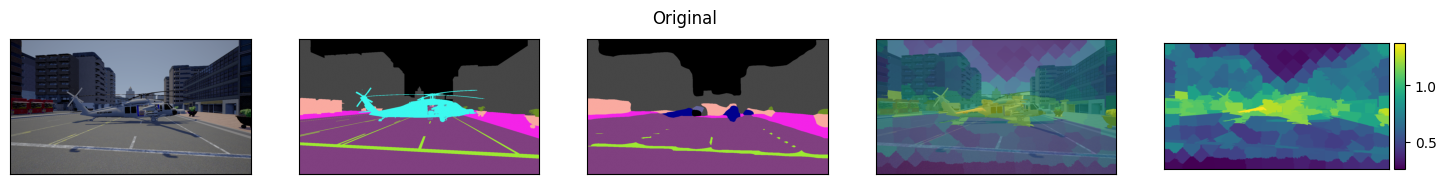

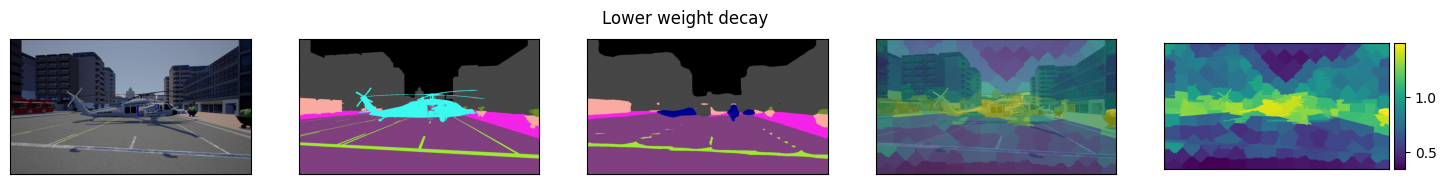

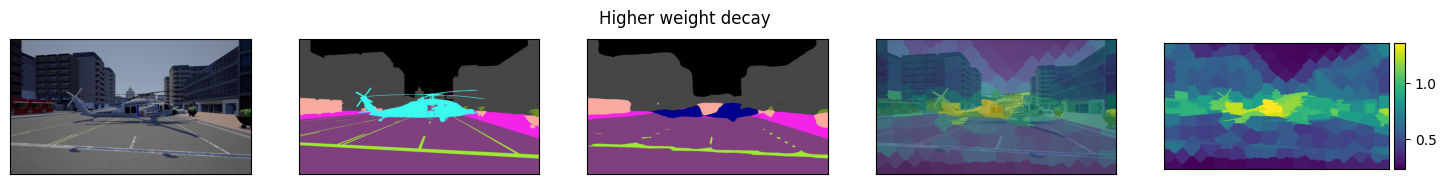

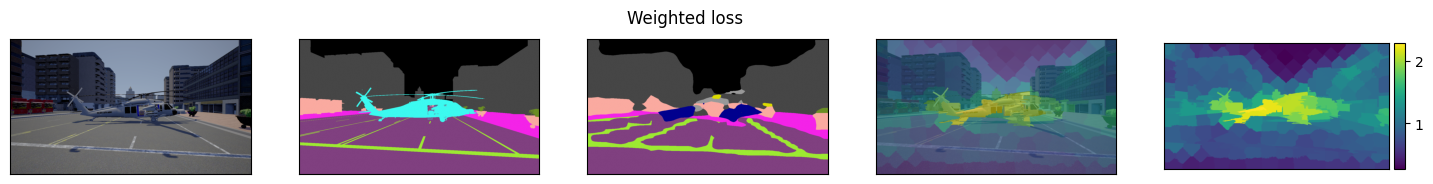

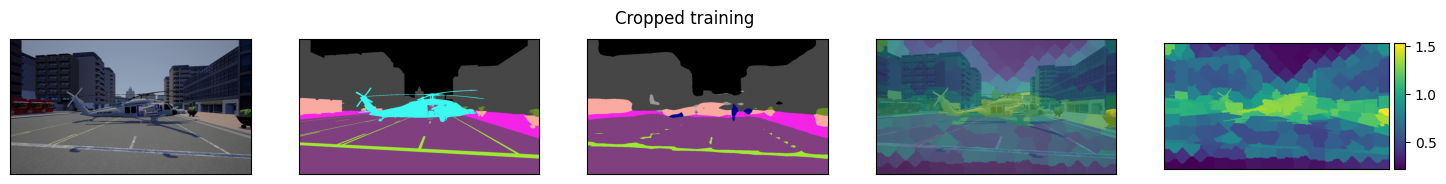

In [39]:
image, labels = __ds_test[1024]
segm_map_main, ood_scores_main = predictors_main["kmeans"](image.unsqueeze(0).to(DEVICE))
segm_map_low_decay, ood_scores_low_decay = predictors_low_decay["kmeans"](image.unsqueeze(0).to(DEVICE))
segm_map_high_decay, ood_scores_high_decay = predictors_high_decay["kmeans"](image.unsqueeze(0).to(DEVICE))
segm_map_loss_weights, ood_scores_loss_weights = predictors_loss_weights["kmeans"](image.unsqueeze(0).to(DEVICE))
segm_map_crop, ood_scores_crop = predictors_crop["kmeans"](image.unsqueeze(0).to(DEVICE))

show_results(image, labels, segm_map_main.cpu().squeeze(0), ood_scores_main.cpu().squeeze(0), title="Original")
show_results(image, labels, segm_map_low_decay.cpu().squeeze(0), ood_scores_low_decay.cpu().squeeze(0), title="Lower weight decay")
show_results(image, labels, segm_map_high_decay.cpu().squeeze(0), ood_scores_high_decay.cpu().squeeze(0), title="Higher weight decay")
show_results(image, labels, segm_map_loss_weights.cpu().squeeze(0), ood_scores_loss_weights.cpu().squeeze(0), title="Weighted loss")
show_results(image, labels, segm_map_crop.cpu().squeeze(0), ood_scores_crop.cpu().squeeze(0), title="Cropped training")

### 5.2. Architecture

In [40]:
# Computed using `calflops`
arch_size = {
    "mobilevit-small": { "gflops": 27.62, "mln_params": 6.36 },
    "mobilevit-xsmall": { "gflops": 14.95, "mln_params": 2.94 },
    "mobilenet": { "gflops": 19.73, "mln_params": 11.02 }
}

#### 5.2.1. Smaller model: DeepLabV3 + MobileViT extra small

As expected, a smaller model worsens both in terms of mIoU and AUPR. However, even with half the parameters, it must be noted that results are still acceptable.

In [41]:
predictors_xsvit = prepare_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-x-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_XS_ABL_DIR, 
    PredictorClass = SmoothedPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "smaller model",
    include = ["kmeans"]
)


if RUN_EVALUATION:
    all_results["val"]["small_model"] = evaluate_segmenter(predictors_xsvit["kmeans"], ds_val, "Segmenter (smaller model)")
    # all_results["val_anom"]["small_model"] = evaluate_models(predictors_xsvit["kmeans"], ds_val_anomalies)
    all_results["test"]["small_model"] = evaluate_models(predictors_xsvit["kmeans"], __ds_test)
else:
    all_results["val"]["small_model"] = [{'model': 'Segmenter (smaller model)', 'miou': 0.46382027907744877, 'iou_c': [0.8303561819868517, 0.7804938098604958, 0.28778075168584105, 0.3059484204770593, 0.0023121956019087914, 0.13047976535674125, 0.3909261114262158, 0.9194183592826688, 0.6848642297466878, 0.7748901503408965, 0.33315474044611043, 0.43285382842509446, 0.15618508337026368]}]
    # all_results["val_anom"]["small_model"] = [{'model': 'k-means + k-NN (smaller model)', 'miou': 0.44592507596396785, 'iou_c': [0.8254290351453872, 0.7754892086759134, 0.27304594102037605, 0.28084142088229364, 0.0025915127955944283, 0.1285566201217228, 0.3857273661043479, 0.9144559179278045, 0.682974910706261, 0.7721122093821896, 0.17586511460506543, 0.4343480361528182, 0.14558869401180705], 'ap': 0.3289076456379583}]
    all_results["test"]["small_model"] = [{'model': 'k-means + k-NN (smaller model)', 'miou': 0.468057163068401, 'iou_c': [0.8443752299328159, 0.7064970556794696, 0.2934165512089188, 0.22871424767146217, 0.0, 0.15195404290696327, 0.34585935923446154, 0.9371999834299224, 0.6644133184879606, 0.7519029855673055, 0.5802760906137971, 0.4043415237819219, 0.1757927313742159], 'ap': 0.11567296370759796}]


display_results(all_results["val"]["small_model"] + all_results["val"]["main"], caption="Results on validation set")
# display_results(all_results["val_anom"]["small_model"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")
display_results(all_results["test"]["small_model"] + [all_results["test"]["main"][-1]], caption="Results on test set")

Model,mIoU
Segmenter (smaller model),46.38
Segmenter,51.05


Model,mIoU,AUPR
k-means + k-NN (smaller model),46.81,11.57
k-means + k-NN,48.30,13.97


#### 5.2.2. Bigger model: DeepLabV3 + MobileNetV3-Large

In [42]:
predictors_mobilenet = prepare_predictors(
    segmenter_card = "deeplabv3_mobilenet",
    segmenter_args = { "image_size": (512, 512) },
    segmenter_ckp_path = DEEPLABV3_MOBILENET_ABL_DIR, 
    PredictorClass = SmoothedPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "MobileNet",
    include = ["kmeans"]
)


if RUN_EVALUATION:
    all_results["val"]["mobilenet"] = evaluate_segmenter(predictors_mobilenet["kmeans"], ds_val, "Segmenter (MobileNet)")
    # all_results["val_anom"]["mobilenet"] = evaluate_models(predictors_mobilenet["kmeans"], ds_val_anomalies)
    all_results["test"]["mobilenet"] = evaluate_models(predictors_mobilenet["kmeans"], __ds_test)
else:
    all_results["val"]["mobilenet"] = [{'model': 'Segmenter (MobileNet)', 'miou': 0.5100038284309021, 'iou_c': [0.8510413604016155, 0.7586052679556001, 0.4779438107611545, 0.26917454683405523, 0.35128421447319086, 0.13689385785777358, 0.4332608018179038, 0.9130017353830095, 0.7134673817450011, 0.7667959094521766, 0.43810371031116, 0.36602234377692927, 0.15445482883215603]}]
    # all_results["val_anom"]["mobilenet"] = [{'model': 'k-means + k-NN (MobileNet)', 'miou': 0.483885116195704, 'iou_c': [0.8492903548159654, 0.7545413004272522, 0.44625843658838055, 0.2537723635236531, 0.222553159402805, 0.13628448492552686, 0.42740587178513917, 0.909364366052148, 0.7049470035463784, 0.7635419254978388, 0.3182117694764053, 0.3593278418835716, 0.1450076326190894], 'ap': 0.3690691734123548}]
    all_results["test"]["mobilenet"] = [{'model': 'k-means + k-NN (MobileNet)', 'miou': 0.4544982051120965, 'iou_c': [0.838459975140815, 0.6860042398946746, 0.28844338355956806, 0.17198338516524433, 0.0, 0.1649088078215275, 0.36128659658523704, 0.940330780772812, 0.6788559061848938, 0.7413313741919513, 0.570505535110801, 0.32056426167979735, 0.14580242034993238], 'ap': 0.1096383883294273}]


display_results(all_results["val"]["mobilenet"] + all_results["val"]["main"], caption="Results on validation set")
# display_results(all_results["val_anom"]["mobilenet"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")
display_results(all_results["test"]["mobilenet"] + [all_results["test"]["main"][-1]], caption="Results on test set")

Model,mIoU
Segmenter (MobileNet),51.00
Segmenter,51.05


Model,mIoU,AUPR
k-means + k-NN (MobileNet),45.45,10.96
k-means + k-NN,48.30,13.97


#### 5.2.3. Wrap-up and qualitative results

### 5.3. Anomaly detector

#### 5.3.1. Feature selection

In [43]:
predictors_embeddings = prepare_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, 
    PredictorClass = StandardPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    hidden_states_index = -2,
    label = "second last embeddings",
    include = ["kmeans"]
)


if RUN_EVALUATION:
    # all_results["val_anom"]["embedding"] = evaluate_models(predictors_embeddings["kmeans"], ds_val_anomalies)
    all_results["test"]["embedding"] = evaluate_models(predictors_embeddings["kmeans"], __ds_test)
else:
    # all_results["val_anom"]["embedding"] = [{'model': 'k-means + k-NN (second last embeddings)', 'miou': 0.47047376637902844, 'iou_c': [0.8482244065442088, 0.7721646018511203, 0.3004418983532618, 0.34274448218232956, 0.06562703760052163, 0.1336815870432678, 0.3615898434476134, 0.9206359110847429, 0.636738245912039, 0.7854702975250939, 0.280590462129206, 0.48915323499937113, 0.17909695425459343], 'ap': 0.28910385343557454}]
    all_results["test"]["embedding"] = [{'model': 'k-means + k-NN (second last embeddings)', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.09286860678635778}]


# display_results(all_results["val_anom"]["embedding"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")
display_results(all_results["test"]["embedding"] + [all_results["test"]["main"][-1]], caption="Results on test set")

Model,mIoU,AUPR
k-means + k-NN (second last embeddings),48.30,9.29
k-means + k-NN,48.30,13.97


#### 5.3.2. Smoothing

In [44]:
predictors_no_smoothing = prepare_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, 
    PredictorClass = StandardPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "no smoothing"
)


if RUN_EVALUATION:
    # all_results["val_anom"]["no_smoothing"] = evaluate_models(predictors_no_smoothing["kmeans"], ds_val_anomalies)
    all_results["test"]["no_smoothing"] = evaluate_models(predictors_no_smoothing["kmeans"], __ds_test)
else:
    # all_results["val_anom"]["no_smoothing"] = [{'model': 'k-means + k-NN (no smoothing)', 'miou': 0.47047376637902844, 'iou_c': [0.8482244065442088, 0.7721646018511203, 0.3004418983532618, 0.34274448218232956, 0.06562703760052163, 0.1336815870432678, 0.3615898434476134, 0.9206359110847429, 0.636738245912039, 0.7854702975250939, 0.280590462129206, 0.48915323499937113, 0.17909695425459343], 'ap': 0.2682315975221909}]
    all_results["test"]["no_smoothing"] = [{'model': 'k-means + k-NN (no smoothing)', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.10847552319560197}]


# display_results(all_results["val_anom"]["no_smoothing"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")
display_results(all_results["test"]["no_smoothing"] + [all_results["test"]["main"][-1]], caption="Results on test set")

Model,mIoU,AUPR
k-means + k-NN (no smoothing),48.30,10.85
k-means + k-NN,48.30,13.97


#### 5.3.3. Wrap-up and qualitative results

---
## 6. Conclusion

### 6.1. Discarded approaches